### Spark ML - A Titanic framework

In this notebook we look at running an ML model in Spark, or more specifically pyspark. The model we will be creating in pyspark is a logistic regression on the Titanic dataset. We are going to calculate the probability of surviving based on few features. I have done no feature engineering so far, because that is not the aim of this notebook. Furthermore, we are going to run the model on our CPU as well as our GPU and time the runs. Here is a depiction of the sinking:


<img src="https://freeenterpriseforum.files.wordpress.com/2014/06/titanic-sinking-credit-redbubble.png">


In [1]:
import pyspark
from pyspark import SparkContext
import tensorflow as tf
sc =SparkContext()
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
from pyspark.sql import Row
from pyspark.sql import SQLContext

#url = "https://github.com/ashishpatel26/Titanic-Machine-Learning-from-Disaster/raw/master/input/train.csv"
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
from pyspark import SparkFiles
sc.addFile(url)
sqlContext = SQLContext(sc)

In [4]:
import pyspark.sql.functions as f
from functools import reduce
df = sqlContext.read.csv(SparkFiles.get("titanic.csv"), header=True, inferSchema= True)
#In my example are columns need to be checked
df = df.drop("Cabin")
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|          330877| 8.4583|       Q|
|          7|      

In [5]:
from pyspark.sql.functions import col, isnan, when, trim
def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))


clean = df.select([to_null(c).alias(c) for c in df.columns]).na.drop(how='any')

In [6]:
clean.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|
|          7|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|           17463|51.8625|       S|
|          8|      

In [7]:
### Example encoder
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

### Code for converting categorical to binary "one hot" values

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
CATE_FEATURES = ['Sex']
stages = [] # stages in our Pipeline
for categoricalCol in CATE_FEATURES:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],
                                     outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

### Convert continuous vars to float

In [9]:
# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 
# List of continuous features
CONTI_FEATURES  = ['Pclass','SibSp','Fare','Parch']

# Convert the type
clean = convertColumn(clean, CONTI_FEATURES, FloatType())

assemblerInputs = [c + "classVec" for c in CATE_FEATURES] + CONTI_FEATURES

### Assemble features and response variable

In [10]:
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Create a pipeline

In [11]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(clean)
model = pipelineModel.transform(clean)

In [12]:
model.take(1)

[Row(PassengerId=1, Survived=0, Pclass=3.0, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1.0, Parch=0.0, Ticket='A/5 21171', Fare=7.25, Embarked='S', SexIndex=0.0, SexclassVec=SparseVector(1, {0: 1.0}), features=DenseVector([1.0, 3.0, 1.0, 7.25, 0.0]))]

In [13]:
from pyspark.ml.linalg import DenseVector
input_data = model.rdd.map(lambda x: (x["Survived"], DenseVector(x["features"])))

In [14]:
df_train = sqlContext.createDataFrame(input_data, ["Survived", "features"])

In [15]:
df_train.show(2)

+--------+--------------------+
|Survived|            features|
+--------+--------------------+
|       0|[1.0,3.0,1.0,7.25...|
|       1|[0.0,1.0,1.0,71.2...|
+--------+--------------------+
only showing top 2 rows



### Split data into test and training sets

In [16]:
# Split the data into train and test sets
train_data, test_data = df_train.randomSplit([.8,.2],seed=1234)

### Import your algorithm of choice

In [17]:
# Import algorithm candidates
from pyspark.ml.classification import LogisticRegression

### Train your model

In [18]:
%%time
# Initialize `lr`
lr = LogisticRegression(labelCol="Survived",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)

# Fit the data to the model
# Change to CPU if u dont have GPU, or just remove the 'with' line

with tf.device('/CPU:0'):
    linearModel = lr.fit(train_data)

Wall time: 2.32 s


In [19]:
%%time
# Initialize `lr`
lr = LogisticRegression(labelCol="Survived",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)

# Fit the data to the model
# Change to CPU if u dont have GPU, or just remove the 'with' line

with tf.device('/GPU:0'):
    linearModel = lr.fit(train_data)

Wall time: 1.41 s


In [21]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(linearModel.coefficients))
print("Intercept: " + str(linearModel.intercept))

Coefficients: [-1.000891332812774,-0.3494195766223486,-0.01672504415074927,0.00320262400666465,0.04101746025437031]
Intercept: 0.8963722532336394


### Evaluate fit of the model
OK so here we look at the ROC and the area under it, typical tests. the further away from the 45 line your model is, better. The area under the curve is 0.83, which isnt too bad on so few of the variables.

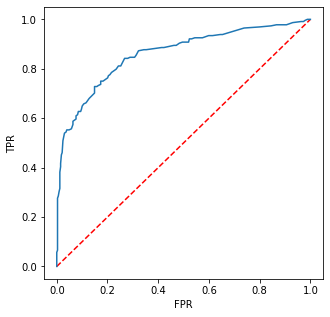

areaUnderROC: 0.8603290140244227


LogisticRegression_46cf1e9f318c

In [22]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = linearModel.summary


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(),
         trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

### Lets see if the above generalizes to the test data set:

In [24]:
# Make predictions on test data using the transform() method.
predictions = linearModel.transform(test_data)

### Create helper function for plotting confusion matrix out, why? Because you can.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
class_temp = predictions.select("Survived").groupBy("Survived")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["Survived"].values.tolist()

In [27]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("Survived")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()
y_true
#y_pred
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[90,  5],
       [33, 27]], dtype=int64)

### Plot confusion matrices for normalized as well as non-normalized values:

Confusion matrix, without normalization
[[90  5]
 [33 27]]


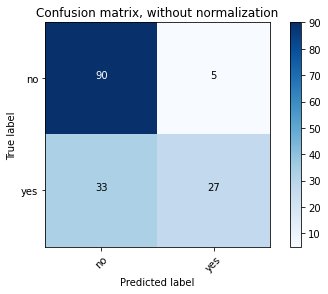

In [28]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['no','yes'],
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.94736842 0.05263158]
 [0.55       0.45      ]]


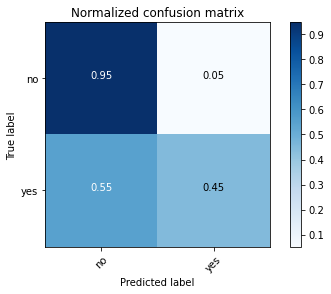

In [29]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['no','yes'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [30]:
selected = predictions.select("Survived", "prediction", "probability")
selected.show(500)

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       1.0|[0.25018605695114...|
|       0|       1.0|[0.44049158841979...|
|       0|       0.0|[0.53084658909043...|
|       0|       0.0|[0.51933075103572...|
|       0|       0.0|[0.52951699943291...|
|       0|       0.0|[0.51613880407137...|
|       0|       0.0|[0.51613880407137...|
|       0|       0.0|[0.53423279502270...|
|       0|       0.0|[0.52787227940317...|
|       0|       0.0|[0.51256003013097...|
|       0|       0.0|[0.53187903049060...|
|       0|       0.0|[0.52337017039778...|
|       0|       0.0|[0.50766776881966...|
|       0|       0.0|[0.50766776881966...|
|       0|       0.0|[0.50081842578882...|
|       0|       0.0|[0.61157527564226...|
|       0|       0.0|[0.59119532597755...|
|       0|       0.0|[0.59119532597755...|
|       0|       0.0|[0.59028879224852...|
|       0|       0.0|[0.58672119026642...|
|       0| 

In [31]:
pip list

Package                  Version
------------------------ -------------------
absl-py                  0.10.0
argon2-cffi              20.1.0
astunparse               1.6.3
async-generator          1.10
attrs                    20.2.0
backcall                 0.2.0
bleach                   3.2.1
cachetools               4.1.1
certifi                  2020.6.20
cffi                     1.14.3
chardet                  3.0.4
colorama                 0.4.3
cycler                   0.10.0
decorator                4.4.2
defusedxml               0.6.0
entrypoints              0.3
gast                     0.3.3
google-auth              1.22.1
google-auth-oauthlib     0.4.1
google-pasta             0.2.0
grpcio                   1.32.0
h5py                     2.10.0
idna                     2.10
importlib-metadata       2.0.0
ipykernel                5.3.4
ipython                  7.18.1
ipython-genutils         0.2.0
ipywidgets               7.5.1
jedi                     0.17.2
Jinja2       

### Other ML algorithms
You can try any of  pysparks ml algorithms. Here is a quick stab at a neural network:

MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_b60d990c1a2c, numLayers=4, numClasses=2, numFeatures=5

Test set accuracy = 0.7290322580645161
Confusion matrix, without normalization
[[84 11]
 [31 29]]


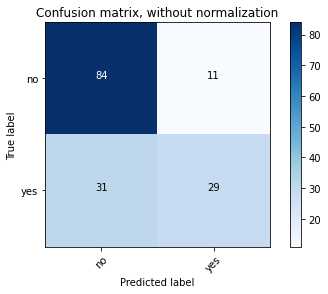

In [60]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load training data


# specify layers for the neural network:
# input layer of size 5 (features), two intermediate of size x1 and x2
# and output of size 2 (classes)
layers = [5,10,3,2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(labelCol="Survived",featuresCol="features",maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train_data)
display(model)
# compute accuracy on the test set
predictions = model.transform(test_data)
predictionAndLabels = predictions.select("prediction","Survived")
evaluator = MulticlassClassificationEvaluator(labelCol="Survived",metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

y_true = predictions.select("Survived")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()
y_true
#y_pred
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['no','yes'],
                      title='Confusion matrix, without normalization')
plt.show()